In [105]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import numpy as np
from fears.utils import results_manager, dir_manager, stats, plotter
from fears.experiment import Experiment
import pandas as pd
import pickle
from lifelines.statistics import logrank_test

np.random.seed(2024)

init_counts = np.zeros(16)
init_counts[0] = 10**5

options = {
    'mut_rate':10**-8,
    'fitness_data':'from_file',
    'use_carrying_cap':True,
    'carrying_cap':10**8,
    'dwell':True,
    'dwell_time':24*4,
    'death_model':'pharmacodynamic',
    'k_elim':0.00839,
    'k_abs':0.95,
    'n_timestep':700,
    'plot':False,
    'regimen_length':10*24,
    'max_dose':30,
    'dose_schedule':12
}


p = np.array([0.0,0.2,0.4,0.6,0.8])

n_sims = 100
debug=False

experiment_type = 'drug-regimen'

e = Experiment(experiment_type=experiment_type,
                n_sims=n_sims,
                prob_drops=p,
                population_options = options,
                results_folder='results',
                debug=debug)

In [92]:
e.run_experiment()

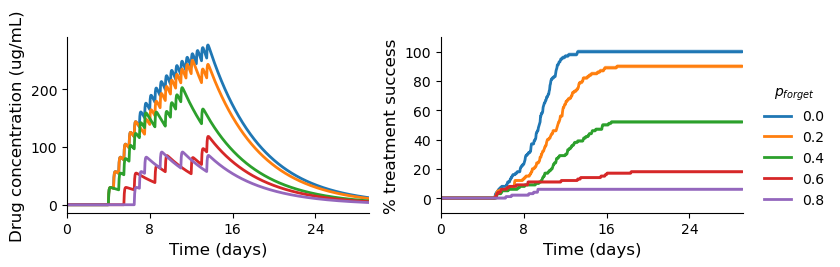

In [127]:
# exp = pickle.load(open(e.experiment_info_path,'rb'))
exp = pickle.load(open('./results/results_03082024_0002/experiment_info_03082024_0002.p','rb'))

resistance_outcome = [1,2]

# exp = pickle.load(open(exp_info_path,'rb'))

data_folder = exp.results_path
exp_info_file = exp.experiment_info_path

exp_folders,exp_info = results_manager.get_experiment_results(exp=exp)

n_sims = exp_info.n_sims
p_drop = exp_info.prob_drops

# fig,ax = plt.subplots(nrows=1,ncols=3,figsize=(8,2.5))
fig,ax_list = plt.subplots(ncols=2,figsize=(8.5,2.5))

ax = ax_list[1]

pop = exp_info.populations[0]

xticks = np.arange(0,pop.n_timestep,24*8)

km_data = stats.km_curve(exp=exp,resistance_outcome=resistance_outcome)
prop_data1 = stats.n_mut_curve(exp=exp,nmut=1)
prop_data2 = stats.n_mut_curve(exp=exp,nmut=2)
prop_data3 = stats.n_mut_curve(exp=exp,nmut=3)
prop_data4 = stats.n_mut_curve(exp=exp,nmut=4)

max_idx_dict = stats.most_freq_genotype(exp=exp,mode=None)

tmax = int(pop.n_timestep)

for p_drop in km_data.keys():
    
    exp_dict = km_data[p_drop]

    death_event_times = exp_dict['survival']

    ax = plotter.plot_kaplan_meier(pop,death_event_times,
                                        ax=ax,
                                        n_sims=n_sims,
                                        label=p_drop,
                                        mode='resistant',
                                        t_max=tmax,
                                        linewidth=2)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

pad = 0.05

ax.set_ylabel('% treatment success',fontsize=12)
ax.set_xlabel('Time (days)',fontsize=12)

# ax.set_title('Survival of infectious agent',fontsize=12)

ax.set_ylim([-10,110])

ax.set_xticks(xticks)

ax = plotter.x_ticks_to_days(pop,ax)

# ax.set_xlim([xmin,xmax])

ax.legend(frameon=False,fontsize=10,loc=(1.05,0),title='$p_{forget}$')

ax = ax_list[0]
n_conditions = len(km_data.keys())

cmap = plt.cm.get_cmap('copper')

# xticks = np.arange(0,pop.n_timestep,96)

indx = 0
for p in exp_info.populations:
    ax.plot(p.drug_curve,linewidth=2,label='$p_{drop}$ = ' + str(p.prob_drop))
    
    ax.set_xticks(xticks)

    ax = plotter.x_ticks_to_days(p,ax)
    # ax.set_xlim([xmin,xmax])
    indx+=1

# ax.legend(frameon=False,fontsize=10)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

ax.set_xlabel('Time (days)',fontsize=12)
ax.set_ylabel('Drug concentration (ug/mL)',fontsize=12)

fig.tight_layout()

# fig.savefig('figures/non_adh_km.pdf',bbox_inches='tight')

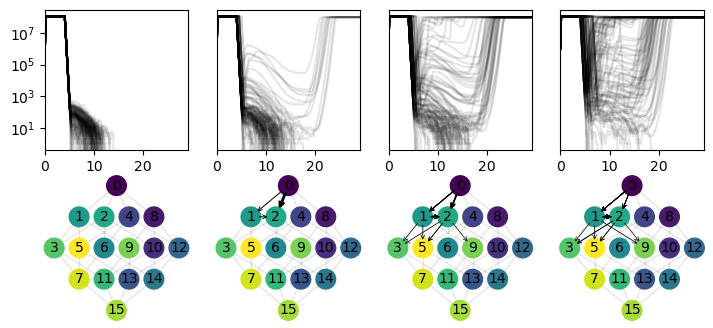

In [134]:
n_conditions = len(km_data.keys())
fig,ax_list = plt.subplots(nrows=2,ncols=n_conditions-1,figsize=(8.5,4),
                            sharex=False,sharey=False)

exp = pickle.load(open('./results/results_03082024_0002/experiment_info_03082024_0002.p','rb'))
arrowprops = dict(arrowstyle='->', color='black', lw=1.5,mutation_scale=7,shrinkA=6,shrinkB=6)

landscape_options = {'node_size':200,
                    'square':True,'node_label':'base10','arrowprops':arrowprops,
                    'resize_param':0.01,'edge_alpha':0.1,'textsize':10}

cmap = plt.get_cmap('Accent')

keys = list(prop_data1.keys())[1:]

p = e.populations[0]

for indx,key in enumerate(keys):
    
    ax = ax_list[0,indx]

    for sim_num in range(n_sims):
        y = stats.get_population_timetrace(sim_num=sim_num,condition_num=indx,exp=exp)
        ax.plot(y,color='black',alpha=0.1)
    ax.set_yscale('log')
    ax.set_xticks(np.arange(0,p.n_timestep,24*10))
    ax = plotter.x_ticks_to_days(p,ax)

    ax.set_yticks([])

    ax = ax_list[1,indx]
    traj_list = []
    for sim_num in range(n_sims):
        
        data = stats.get_sim_data(sim_num=sim_num,condition_num=indx,exp=exp)

        if np.sum(data[-1,:]) > 0:

            trajectory = [0]
            for t in range(len(data[:,0])):
                pop = data[t,:]
                max_gen = np.argmax(pop)
                if max_gen != trajectory[-1]:
                    trajectory.append(max_gen)

            if len(trajectory) > 1:
                traj_list.append(trajectory)

    # count the number of each unique trajectory
    
    traj_list = [tuple(traj) for traj in traj_list]

    traj_list_unique = list(set([tuple(traj) for traj in traj_list]))  
    
    traj_list_count = np.zeros((len(traj_list_unique)))
    
    for j,traj in enumerate(traj_list_unique):
        traj_list_count[j] = traj_list.count(traj)

    traj_list_count = 5*(np.array(traj_list_count)/np.sum(traj_list_count))**2

    traj_list_count[traj_list_count < 0.5] = 0.5

    plotter.plot_landscape(p,trajectory_list=traj_list_unique,conc=np.mean(p.drug_curve),ax=ax,
                           colorbar=False,weight_list=traj_list_count,**landscape_options)
    
yt = [10**1,10**3,10**5,10**7]

ax_list[0,0].set_yticks(yt)

xticks = np.arange(0,p.n_timestep,24*8)


    ###########################################################################

# fig.savefig('figures/nonadherence_grid.pdf',bbox_inches='tight')

In [133]:
exp

'results/results_03082024_0002/p_drop=0,2'

In [96]:
# fig,ax = plt.subplots(figsize=(4,4))

# cmap = plt.cm.get_cmap('copper')

# xticks = np.arange(0,pop.n_timestep,96)

# indx = 0
# for p in exp_info.populations:
#     ax.plot(p.drug_curve,color=cmap(indx/(n_conditions-1)),linewidth=2,label='$p_{drop}$ = ' + str(p.prob_drop))
    
#     ax.set_xticks(xticks)

#     ax = plotter.x_ticks_to_days(p,ax)
#     ax.set_xlim([xmin,xmax])
#     indx+=1

# ax.legend(frameon=False,fontsize=10)
# ax.spines["right"].set_visible(False)
# ax.spines["top"].set_visible(False)

# ax.set_xlabel('Time (days)',fontsize=12)
# ax.set_ylabel('Drug concentration (ug/mL)',fontsize=12)

In [97]:
def compute_doses(regimen,pop):

    dose_schedule = pop.dose_schedule/pop.timestep_scale
    n_doses = int(np.floor(pop.regimen_length/dose_schedule))

    doses = np.zeros(n_doses)

    dose_num = 0

    for i in range(n_doses):
        if regimen[int(i*dose_schedule)] == 1:
            doses[dose_num] = 1
        dose_num += 1
    
    return doses

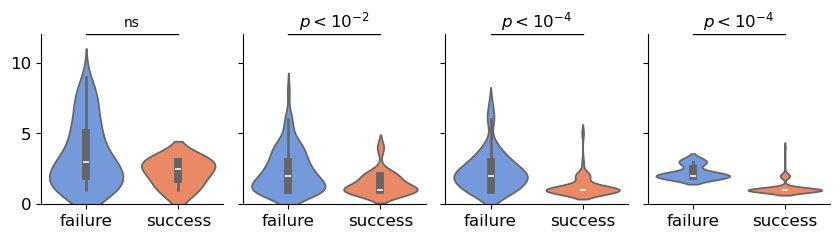

In [148]:
import scipy.stats as spstats

def conf_interval(n1,x1,n2,x2):
    """99% confidence interval for risk ratio

    Args:
        n1 (int): number of trials in group 1
        x1 (int): number of successes in group 1
        n2 (int): number of trials in group 2
        x2 (int): number of successes in group 2

    Returns:
        float: 99% confidence interval
    """
    return 2.576*np.sqrt((n1-x1)/(n1*x1) + (n2-x2)/(n2*x2))

pop = exp_info.populations[0]

gap = int(pop.dose_schedule/pop.timestep_scale)     
if pop.dwell:
    dwell_doses = int(np.floor(pop.dwell_time/gap))
else:
    dwell_doses = 0

# n_scheduled_doses = int(np.floor(pop.n_timestep/gap))-dwell_doses
n_scheduled_doses = int(np.floor(pop.regimen_length/gap))-dwell_doses

max_doses = int(np.sum(pop.impulses))

n_subplots = len(exp_folders)-1
fig,ax_list = plt.subplots(ncols=n_subplots,figsize=(8.5,2.5),sharey=True,sharex=True)

exp_folders = np.array(exp_folders)
exp_folders_t = np.flip(exp_folders[[1,2,3,4]])
exp_folders_t = list(exp_folders_t)
exp_folders_t = [str(x) for x in exp_folders_t]
p_drop = exp_info.prob_drops
num = 0

for exp in exp_folders_t:

    # ax = ax_list[num]
    extinct_sched = np.zeros(n_scheduled_doses)
    extinct_sched = np.array([extinct_sched])
    survived_sched = np.zeros(n_scheduled_doses)
    survived_sched = np.array([survived_sched])
    sim_files = os.listdir(path=exp)
    sim_files = sorted(sim_files)

    p_drop_t = exp[exp.find('=')+1:]
    p_drop_t = p_drop_t.replace(',','.')
    p_drop_t = float(p_drop_t)
    
    # num = np.argwhere(p_drop == p_drop_t)
    # num = num[0,0]
    k=0
    while k < len(sim_files):

        sim = sim_files[k]
        sim = exp + os.sep + sim
        data_dict = results_manager.get_data(sim)
        counts = data_dict['counts']
        counts = np.sum(counts,axis=1)
        # dc = data_dict['drug_curve']
        regimen = data_dict['regimen']
        dose_schedule = compute_doses(regimen,pop)
        dose_schedule = dose_schedule[dwell_doses:]
        dose_schedule = np.array([dose_schedule])
        # dose_schedule = dose_schedule[dwell_doses:]

        if counts[-1]<1:
            extinct_sched = np.concatenate((extinct_sched,dose_schedule),axis=0)
        else:
            survived_sched = np.concatenate((survived_sched,dose_schedule),axis=0)
        k+=1

    extinct_sched = extinct_sched[1:,:]
    survived_sched = survived_sched[1:,:]

    cmap = mpl.colors.ListedColormap(['cornflowerblue','w'])

    n_extinct = extinct_sched.shape[0]
    n_survived = survived_sched.shape[0]

    survived_hist = np.sum(survived_sched,axis=0)
    sh_counts = survived_hist
    survived_hist = survived_hist/n_survived
    extinct_hist = np.sum(extinct_sched,axis=0)
    ext_counts = extinct_hist
    extinct_hist = extinct_hist/n_extinct

    dose_num = np.arange(len(survived_hist)) + 1

    ax = ax_list[num]

    time_between_surv = []
    time_between_ext = []

    for s in survived_sched:
        # print(s)
        doses = np.argwhere(s==1)
        if len(doses) > 1:
            time_between_surv.append((doses[1]-doses[0])[0])
    for ext in extinct_sched:
        doses = np.argwhere(ext==1)
        if len(doses) > 1:
            time_between_ext.append((doses[1]-doses[0])[0])

    d = {'survived':time_between_surv,
            'extinct':time_between_ext}
    
    sns.violinplot(ax=ax,data=[time_between_surv,time_between_ext],
                    palette=['cornflowerblue','coral'])
    
    # display a horizontal line over the violin plot

    ax.plot([0,1],[12,12],'k',linewidth=1)

    t_stat,p_val = spstats.ttest_ind(time_between_surv,time_between_ext,equal_var=False)

    if p_val < 0.05:

        log_val = str(round(np.log10(p_val)) + 1)

        ax.text(0.5,12.5,'$p < 10^{' + log_val + '}$',fontsize=12,ha='center')

    else:
        ax.text(0.5,12.5,'ns',fontsize=10,ha='center')
    
    # ax.tight_layout()
    xt = ax.get_xticks()
    ax.set_xticks(xt)
    ax.set_xticklabels(['failure','success'])

    ax.set_yticks([0,5,10,15,20])
    # ax.set_ylim(0,12)

    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)

    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

    num+=1

ax_list[0].set_ylabel('Time between doses (hours)')

fig.tight_layout()

In [151]:
time_between_surv

[2, 2, 2, 2, 2, 3, 3, 3, 2, 2, 2]